In [1]:
!rm -rf ./logs/
!pip install tensorflow_datasets
!pip install -q -U keras-tuner
!pip install -q pyyaml h5py

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout, BatchNormalization 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.callbacks import TensorBoard
import urllib, IPython, os, datetime, re, nltk, tensorboard, operator, json, requests
from nltk.corpus import stopwords
import kerastuner as kt
import matplotlib.pyplot as plt
import tensorflow.keras.activations as activations
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.losses as losses
import tensorflow.keras.optimizers as optimizers
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

nltk.download('punkt')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
session_id = datetime.datetime.now().strftime("%d/%m/%Y-%H:%M")

Add the file names which should be processed. Files should be named after philosophers (e.g. `plato.txt`).

In [5]:
file_names = [
    'kant.txt', 
    'nietzsch.txt', 
    'platon.txt', 
    'rousseau.txt']
phil_names = [name[:-4].capitalize() for name in file_names]

# Preparation / normalization

### Loading files with Keras

In [6]:
prefix = 'file://'
processed_path = '/content/drive/My Drive/RUAK/input/processed/'
url = urllib.parse.quote(processed_path)

for file_name in file_names:
  text_dir = tf.keras.utils.get_file(file_name, origin=prefix+url+file_name)

parent_dir = os.path.dirname(text_dir)

3874816/3867231 [==============================] - 0s 0us/step


## Load stop words

In [191]:
def replace_umlaut(string):
    string = string.replace('ä', 'ae')
    string = string.replace('ö', 'oe')
    string = string.replace('ü', 'ue')
    string = string.replace('Ä', 'Ae')
    string = string.replace('Ö', 'Oe')
    string = string.replace('Ü', 'Ue')
    string = string.replace('ß', 'ss')
    return string

response = json.loads(requests.get('https://countwordsfree.com/stopwords/german/json').text)
stop_words = [replace_umlaut(word) for word in response['words']]
print(f'Loaded {len(stop_words)} stop words.')

Loaded 592 stop words.


# Data managment

In [231]:
def add_words(sentence):
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word == '':
      continue
    if word.lower() not in stop_words:
      words_without_stop_words.append(word)
      unique_words_without_stop_words.add(word)

words_without_stop_words = []
unique_words_without_stop_words = set()

Extract sentences from files and creates labels list. Adjust the language for the `nltk.sent_tokenizer` if needed.

In [233]:
sentences = []
labels = []

for index, file_name in enumerate(file_names):
  path = os.path.join(parent_dir, file_name)

  with open(path, 'rb') as file: 
    text = str(file.read())
    nltk_sentences = nltk.sent_tokenize(text, language='german')

    for sentence in nltk_sentences:
      if ' ' in sentence == False:
        continue
      if len(sentence) <= 20:
        continue
      sentence = str(sentence).replace("b'", "")
      sentences.append(sentence)
      labels.append(index)
      add_words(sentence)

    print(f"Sentences for {file_name} with label: {index} added.")

print(f'\n{len(sentences)} sentences found.')
print(f'{len(words_without_stop_words)} words found (excl. stop words).')
print(f'{len(unique_words_without_stop_words)} unique words found (excl. stop words).')

Sentences for kant.txt with label: 0 added.
Sentences for nietzsch.txt with label: 1 added.
Sentences for platon.txt with label: 2 added.
Sentences for rousseau.txt with label: 3 added.

87710 sentences found.
1799830 words found (excl. stop words).
88401 unique words found (excl. stop words).


Collect all words except the stop words. Those can be used for further analysis.

In [250]:
most_common = [keyword[0] for keyword in Counter(words_without_stop_words).most_common(20)]
most_common_count = mydict = {k: v for k, v in Counter(words_without_stop_words).most_common(20)}

# Visualization of data

Prepate Pandas DataFrame

In [147]:
data = {'label': labels, 'sentence': sentences}
df = pd.DataFrame(data)

Calculate `stop_word_quote`

In [168]:
def stop_word_quote(sentence):
  count = 0
  for word in sentence.split():
    word = re.sub(r"[^a-zA-Z]+", "", word)
    if word.lower() in stop_words:
      count += 1
  return round(count/len(sentence.split()) * 100, 2)

Add new columns to dataframe.

In [ ]:
df['length'] = df['sentence'].str.split().str.len()
df['stop_words_quote'] = df['sentence'].map(stop_word_quote)
df['philosopher'] = df['label'].map(lambda x: phil_names[x])

In [169]:
df.head(len(sentences))

,label,sentence,length,stop_word_quote,philosopher
0,0,"Ich habe einen Vorwurf gewaehlt, welcher sowo...",32,53.12,Kant
1,0,"Das Systematische, welches die grossen Glieder...",49,53.06,Kant
2,0,Von der andern Seite droht die Religion mit ei...,51,54.90,Kant
3,0,Ich sehe alle diese Schwierigkeiten wohl und w...,11,72.73,Kant
4,0,Ich empfinde die ganze Staerke der Hindernisse...,15,60.00,Kant
...,...,...,...,...,...
87705,3,Wer sich aber zu sagen erdreistet: ausser der ...,32,62.50,Rousseau
87706,3,Ein solches Dogma steht nur mit einer theokrat...,17,64.71,Rousseau
87707,3,"Der Grund, aus dem Heinrich zur katholischen K...",25,52.00,Rousseau
87708,3,Nachdem ich die wahren Grundsaetze des Staatsr...,55,52.73,Rousseau


Get values for visualization

In [171]:
median_sentence_length = df.groupby('philosopher')['length'].median()
mean_stop_words = df.groupby('philosopher')['stop_words_quote'].mean()
sentence_count = df.groupby('label')['sentence'].count()

Draw Visualization

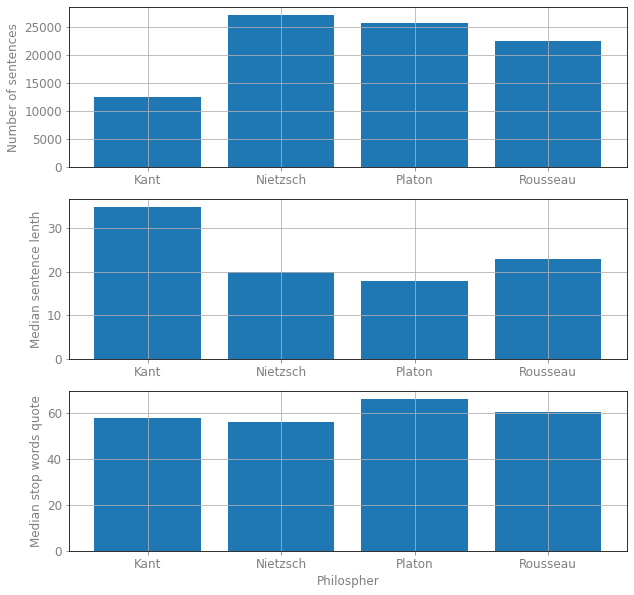

In [172]:
fig, axs = plt.subplots(3,1, figsize=(10,10))

axs[0].bar(phil_names, sentence_count)
axs[0].set_ylabel('Number of sentences', fontdict={'color':'gray', 'size':12})
axs[0].tick_params(axis='both', colors='gray', labelsize=12)
axs[0].grid()

axs[1].bar(phil_names, median_sentence_length)
axs[1].set_ylabel('Median sentence lenth', fontdict={'color':'gray', 'size':12})
axs[1].tick_params(axis='both', colors='gray', labelsize=12)
axs[1].grid()

axs[2].bar(phil_names, mean_stop_words)
axs[2].set_xlabel('Philospher', fontdict={'color':'gray', 'size':12})
axs[2].set_ylabel('Median stop words quote', fontdict={'color':'gray', 'size':12})
axs[2].tick_params(axis='both', colors='gray', labelsize=12)
axs[2].grid()

plt.show()

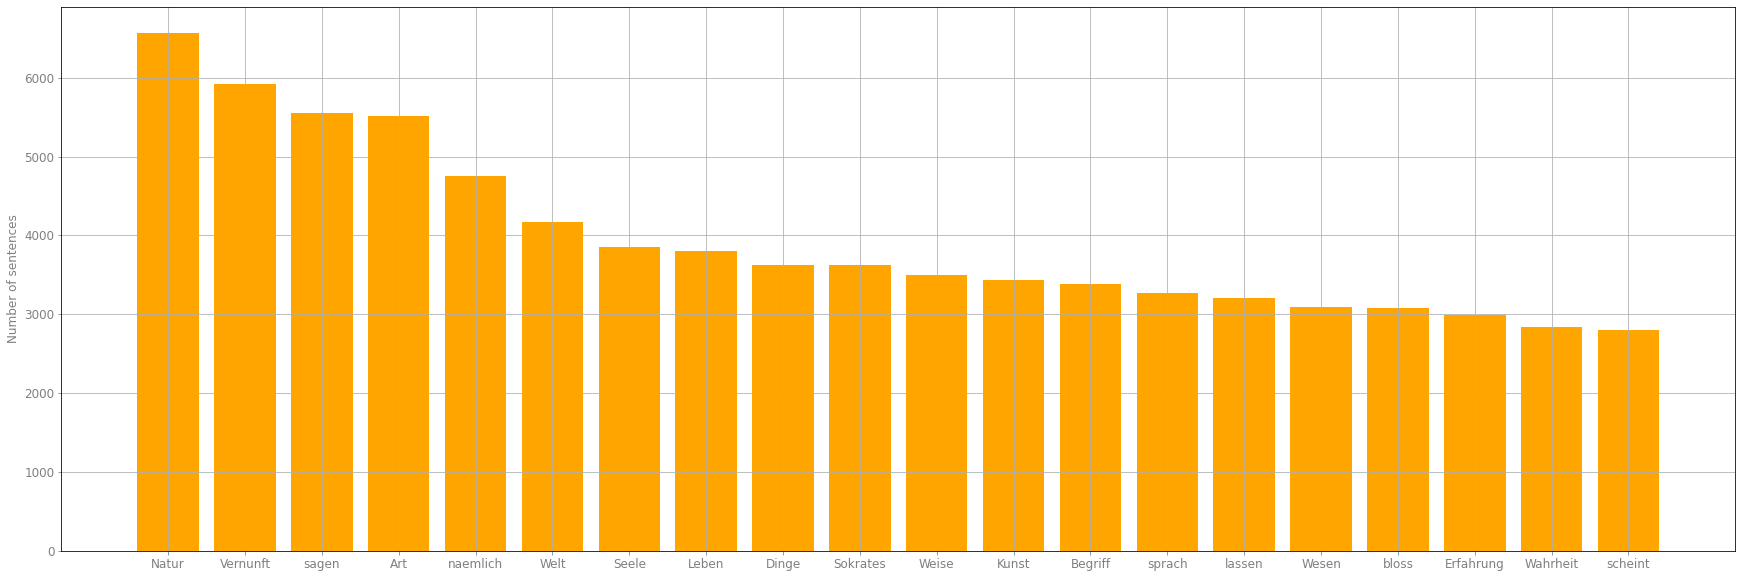

In [263]:
fig, axs = plt.subplots(1,1, figsize=(30,10))

axs.bar(most_common_count.keys(), most_common_count.values(), color='orange')
axs.set_ylabel('Number of sentences', fontdict={'color':'gray', 'size':12})
axs.tick_params(axis='both', colors='gray', labelsize=12)
axs.grid()

plt.show()

# Tokenization

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
print(f'{len(sentences)} sentences from {len(file_names)} authors.')
print(f'{len(tokenizer.word_counts)} unique vocabularies.')

87710 sentences from 4 authors.
79401 unique vocabularies.


# Encoding

In [9]:
encoded_sentences = tokenizer.texts_to_sequences(sentences)
padded_sentences = pad_sequences(encoded_sentences, padding='post')

Test the encoder

In [ ]:
print(sentences[7])
print(np.array(padded_sentences[7]))
print(tokenizer.sequences_to_texts([padded_sentences[7]]))

# Splitting

Create train and test data for the fitting proccess.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(padded_sentences, np.array(labels), test_size=0.1)
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(78939, 430)
(78939,)
(8771, 430)
(8771,)


# Hyperparameter tuning

### setup the test model

Load the Word2Vec model (700 dims, 100 epochs, window 7) for providing the weights for the embedding layer.

In [12]:
model_path = os.path.abspath("/content/drive/My Drive/RUAK/output/embedding/w2v/") # This path may need to be changed.

def get_embedding_matrix(model_name):
    model = Word2Vec.load(f'{model_path}/{model_name}')
    embedding_matrix = np.zeros((len(model.wv.vocab), model.vector_size))
    
    for i in range(len(model.wv.vocab)):
        embedding_vector = model.wv[model.wv.index2word[i]]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    print(f"Embedding_matrix shape: {embedding_matrix.shape}")
    return embedding_matrix

embedding_matrix = get_embedding_matrix('full_700_iter100_win7_8.model')

Embedding_matrix shape: (132919, 700)


Hyperparameter Tuning

In [13]:
def hypermodel(hp):

  hp_dense_count = hp.Int('dense_count', min_value=1, max_value=7, step=1)
  hp_embedding_trainable = hp.Choice('embedding_trainable', [True, False])
  hp_with_batch_normalization = hp.Choice('with_batch_normalization', [True, False])
  hp_lstm_units = hp.Int('lstm_units', 256, 512, step=128)
  hp_dropout = hp.Choice('dropout', [0.0, 0.1, 0.25])
  hp_learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])
  hp_adam_epsilon = hp.Choice('adam_epsilon', values=[1e-07, 1e-08])

  model = tf.keras.Sequential()
                                    
  model.add(Embedding(len(embedding_matrix),
                    output_dim=700,
                    weights=[embedding_matrix], 
                    trainable=hp_embedding_trainable,
                    mask_zero=True))
  
  model.add(Bidirectional(LSTM(hp_lstm_units, return_sequences=True)))
  if hp_embedding_trainable == True:
    BatchNormalization()
  model.add(Dropout(hp_dropout))

  model.add(Bidirectional(LSTM(hp_lstm_units, return_sequences=True)))
  if hp_embedding_trainable == True:
    BatchNormalization()  
  model.add(Dropout(hp_dropout))

  model.add(Bidirectional(LSTM(hp_lstm_units)))
  if hp_embedding_trainable == True:
    BatchNormalization()  
  model.add(Dropout(hp_dropout))

  for i in range(hp_dense_count):
    hp_dense_units = hp.Int(f'dense_units{i}', 64, 512, step=64)
    hp_dense_activation = hp.Choice(f'dense_activation_{i}', values=['tanh', 'relu'])
    model.add(Dense(hp_dense_units, activation=hp_dense_activation))

  model.add(Dense(len(file_names), activation='softmax'))

  model.compile(optimizer=optimizers.Adam(learning_rate=hp_learning_rate, epsilon=hp_adam_epsilon),
              loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

### Run the tuner

Some parameters needed for tuning and training

In [14]:
batch_size=40
epochs=1
search_epochs=1
early_stopping_patience=5
executions_per_trial=1
hyperband_iterations=1

The result are the optimal hyperparameters: `best_hps`.

In [15]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait=True)

tuner = kt.Hyperband(hypermodel,
                     objective='val_accuracy', 
                     executions_per_trial=executions_per_trial,
                     factor=3,
                     max_epochs=epochs+5,
                     hyperband_iterations=hyperband_iterations,
                     directory='/content/drive/My Drive/RUAK/output/hp_tuning', # This path may need to be changed.
                     project_name='RUAK',
                     overwrite=True)

tuner.search(X_train, y_train, 
             epochs=search_epochs,
             validation_data = (X_valid, y_valid),
             callbacks = [ClearTrainingOutput(), EarlyStopping('val_accuracy', patience=1)],
             verbose=2)

best_hps = tuner.get_best_hyperparameters(1)[0]
best_models = tuner.get_best_models(num_models=3)

print(f"""
Optimal values:
- embedding is trainable {best_hps.get('embedding_trainable')}
- number of units for dense layers {best_hps.get('dense_units')}
- number of units for lstm layers {best_hps.get('lstm_units')}
- learning rate {best_hps.get('learning_rate')}
- dropout rate {best_hps.get('dropout')}
""")

tuner.results_summary()

Epoch 1/2


KeyboardInterrupt: ignored

# TensorBoard preparations

In [ ]:
%load_ext tensorboard
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%d/%m/%Y - %H:%M"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Model preparation

Get summaries of the best models and choose the model for training.

In [ ]:
for model in best_models:
  model.summary()

In [ ]:
chosen_model = best_models[0] # Choose preferred model 

### Prepare callbacks

In [ ]:
checkpoint_path = f"/content/drive/My Drive/RUAK/output/training_checkpoints/{session_id}/cp.ckpt" # This path may need to be changed.
checkpoint_dir = os.path.dirname(checkpoint_path)

model_path = f"/content/drive/My Drive/RUAK/output/models/model-{session_id}.h5" # This path may need to be changed.

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

es_callback = EarlyStopping('val_accuracy', patience=early_stopping_patience, restore_best_weights=True)

# Model training

In [ ]:
 history = chosen_model.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=batch_size, 
                            validation_data=(X_valid, y_valid), 
                            callbacks=[cp_callback, es_callback])

1754/1755 [============================>.] - ETA: 0s - loss: 0.9626 - accuracy: 0.7776
Epoch 00001: saving model to /content/drive/My Drive/RUAK/output/training_checkpoints/12/11/2020-07:54/cp.ckpt
1755/1755 [==============================] - 254s 145ms/step - loss: 0.9626 - accuracy: 0.7776 - val_loss: 0.9659 - val_accuracy: 0.7743


Save the model

In [ ]:
model.save('/content/drive/My Drive/RUAK/output/models/phil_model.h5') # This path may need to be changed.

# Loading

### Load model

In [ ]:
chosen_model = tf.keras.models.load_model('/content/drive/My Drive/RUAK/output/models/phil_model.h5') # This path may need to be changed.

### Load stored weights

`{ID}` needs to be provided. Should be some kind of `session_id`.

In [ ]:
checkpoint_id = # Place the `session_id`

In [ ]:
checkpoint_path = f"/content/drive/My Drive/RUAK/training_checkpoints/{checkpoint_id}/cp.ckpt" # This path may need to be changed.
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
chosen_model.load_weights(latest)

# Evaluate

In [ ]:
test_loss, test_acc = chosen_model.evaluate(valid_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

439/439 [==============================] - 23s 52ms/step - loss: 1.0065 - accuracy: 0.7349
Test Loss: 1.0064799785614014
Test Accuracy: 0.7349218726158142


Test the model. Add a `sample_sentence` to get the probability distribution for each author.

In [ ]:
sample_sentence = "Die Vernunft ist staerker als der Wille."

In [ ]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

def sample_predict(sample_text, pad):
  encoded_sample_text = encoder.encode(sample_text)
  if pad:
    encoded_sample_text = pad_to_size(encoded_sample_text, batch_size)
  encoded_sample_text = tf.cast(encoded_sample_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_text, 0))
  return (predictions)

predictions = sample_predict(sample_sentence_text, pad=True)

print(predictions)

[[9.8962909e-01 1.0056574e-02 1.0725544e-04 2.0699060e-04]]


# TensorBoard analysis

In [ ]:
%tensorboard --logdir logs